In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')

import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [2]:
train_motions = ['01', '02', '03', '04', '05', '06', '07', '08']
test_motions = ['09', '10']
subject = '64'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m_golf = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=3, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m_golf['Y'], m_golf['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m_golf['Ytest'], m_golf['lblstest'])

## Preprocess the data to remove the initial stable period.
## 1:40, 2:60, 3:40, 4:40, 5:30, 6:30
train_map = [40, 60, 40, 40, 30, 30, 30, 25]
test_map = [45, 60]

y_train_list = []
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data([item[j][train_map[j]:,:] for j in range(8)])
    y_train_list.append(out)
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_list = []
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data([item[j][test_map[j]:,:] for j in range(2)])
    y_test_list.append(out)
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    
y_train = helper.reshape(y_train_list)
y_train_mean = helper.reshape(y_train_mean_list)
y_train_std = helper.reshape(y_train_std_list)

y_test = helper.reshape(y_test_list)
y_test_mean = helper.reshape(y_test_mean_list)
y_test_std = helper.reshape(y_test_std_list)


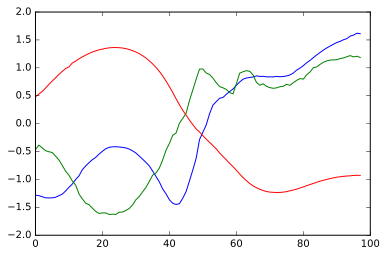

In [10]:
plot(y_train[3][:,:3]) # sample every 3 frames

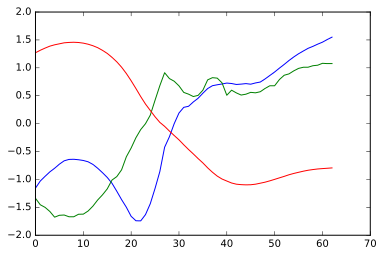

In [16]:
plot(y_train[3][:,:3]) # sample every 4 frames

# no control

In [4]:
## --- Training --- ##
## Initialize model
YD = np.shape(y_train[0])[1]
HD = 1
win_out = 20

m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
        kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
    
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,))*50,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.01]),np.float64))    

## Train model
m.optimize(Y=y_train, max_iters=300, step_rate=0.02)
m.optimize(Y=y_train, max_iters=1000, step_rate=0.01)
# m.optimize(Y=y_train, max_iters=1500, step_rate=0.01)
# m.optimize(Y=y_train, max_iters=1000, step_rate=0.005)
    
## Save model
m.save_params('./models/no_control_golf1') 

100%|██████████| 1000/1000 [2:27:07<00:00,  8.83s/it, loss=-3.11e+04] 


In [5]:
def test_run(model, seq, win_out,  test_data, HD, win_in=None,control_signal=None, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
        
        
        m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=100,
                kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                         U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    else:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        
    
        m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
                kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True,dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200, 200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [7]:
## --- testing --- ##
win_out = 20
HD=1

num_test_seq = np.shape(y_test_list)[1]
y_pds = [[] for _ in range(num_test_seq)]
u_test_list = []
for seq in range(num_test_seq):
    y_pds[seq] = test_run('no_control_golf1', seq, win_out, y_test, HD, MEAN_PRED=True, with_control=False) # output array
    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, y_test_mean[seq], y_test_std[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/no_control_golf1_seq'+str(seq)
    helper.write_amc(pd, filename)

Observationa dimension: 62
Observationa dimension: 62


In [8]:
# HD=1
print(helper.compute_MSE(y_test_list, y_pds))

[0.22597524497167945, 0.13707448770365296]


In [18]:
# HD=3
print(helper.compute_MSE(y_test_list, y_pds))

[0.25215465306522905, 0.1337361980704932]


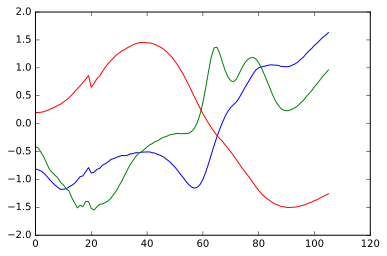

In [19]:
## prediction
plot(y_pds[0][:,:3])

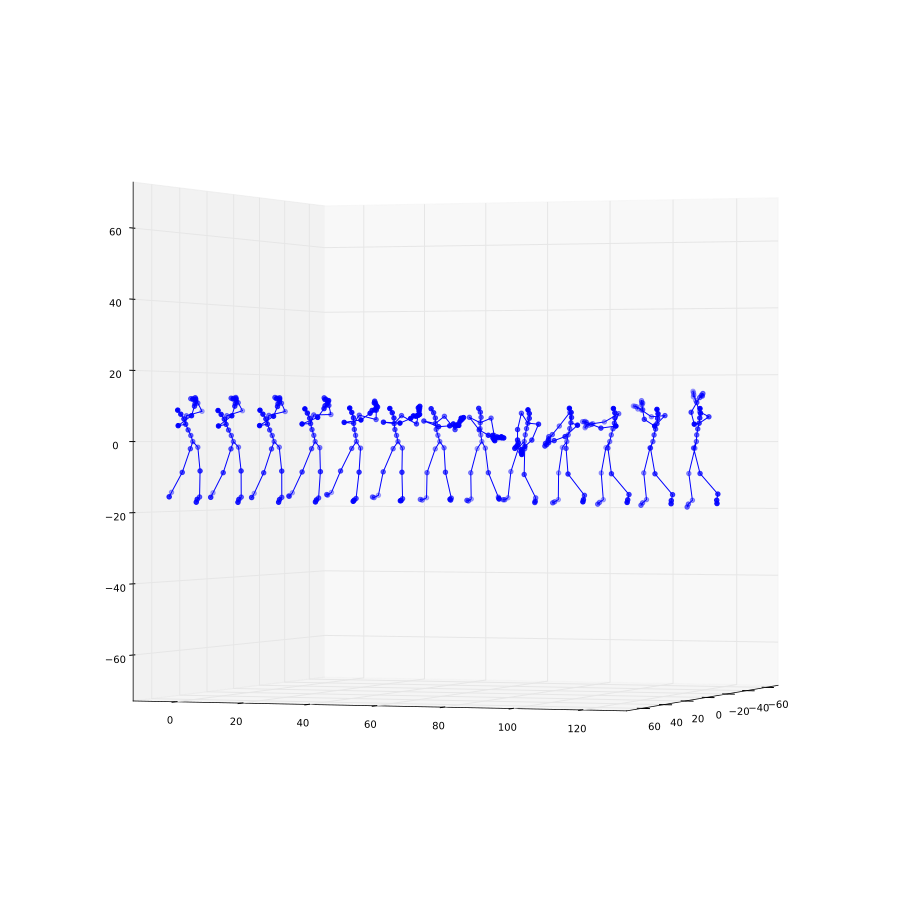

In [20]:
helper.save_trail(y_pds[0][:,3:], y_test_mean[0][3:], y_test_std[0][3:], m_golf['skel'], "no_control_golf3")

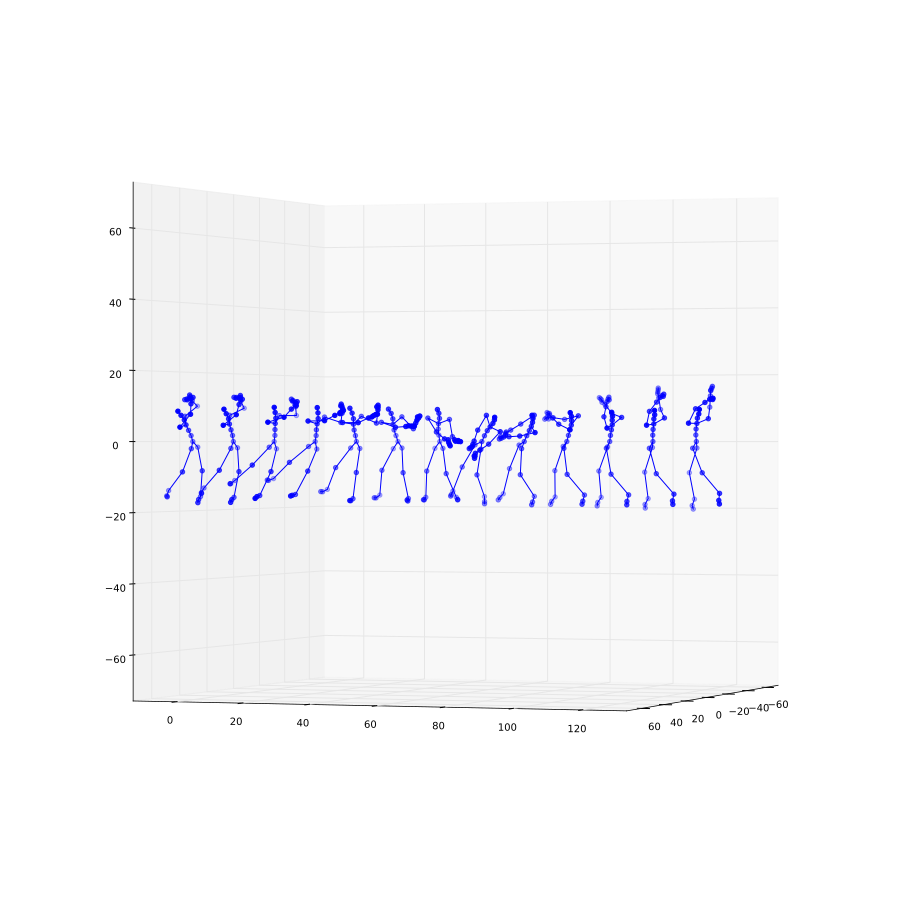

In [10]:
helper.save_trail(y_pds[1][:,3:], y_test_mean[1][3:], y_test_std[1][3:], m_golf['skel'], "no_control_golf1")

Conclusion:
    Hidden layer 3 dimension gives the best prediction.